# Neo4J v058 test1 - Trellis : Sample based Analysis

    -  Check the success case only based on outputs
    -  Load the account info from Google Cloud Storage
    -  Remove Duplicate jobs and Duplicate jobs and nodes status
    -  Add 'dup' column with the number of dupilcated jobs
    
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [166]:
#!pip3 install -U py2neo

# *** add python path of py2neo in system

#!pip3 install -U neotime
#!pip3 install -U neobolt
#!pip3 install -U pandas-gbq

### Import Packages

In [167]:
import py2neo as neo
from py2neo import Graph

from google.cloud import storage
import yaml

import pandas as pd
import pandas_gbq

import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Neo4J DB

In [168]:
## Option 1 : Read DB and Account Information in Google Storage (YAML)

# create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket('gbsc-gcp-project-mvp-test-trellis')
# get bucket data as blob
blob = bucket.get_blob('credentials/test-wgs35.yaml')
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

## Main Account
graph = Graph(account['NEO4J_SCHEME']+'://'+account['NEO4J_HOST']+":"+str(account['NEO4J_PORT']), auth=(account['NEO4J_USER'],account['NEO4J_PASSPHRASE']))

## Generate Sample Status Table

### The number of nodes (Fastq, Ubam, Vcf, Cram, Crai) 

In [169]:
# Fastq
#query = "MATCH (s:Sample)-[:HAS]->(f:Fastq) RETURN s.sample AS sample, COUNT(f) AS fastq"
query = "MATCH (s:Sample), (f:Fastq) WHERE s.sample = f.sample RETURN s.sample AS sample, COUNT(f) AS fastq"
#query = "Match (j:sample), (f:Fastq) WHERE f.sample = j.sample RETURN j.sample AS sample, count(f) AS fastq"
num_fastq = graph.run(query).to_data_frame()
num_fastq.set_index('sample')

# Fastq RG
#query = "MATCH (s:Sample)-[:HAS]->(f:Fastq) RETURN s.sample AS sample, f.readGroup AS rg, count(f.readGroup) as rg_cnt"
query = "MATCH (s:Sample), (f:Fastq) WHERE s.sample = f.sample RETURN s.sample AS sample, f.readGroup AS rg, count(f.readGroup) as rg_cnt"
#query = "Match (j:sample), (f:Fastq) WHERE f.sample = j.sample RETURN j.sample AS sample, count(f) AS fastq"
num_fastq_rg = graph.run(query).to_data_frame()
num_fastq_rgm=num_fastq_rg.loc[num_fastq_rg['rg_cnt']==2,['sample','rg']]

num_fastq_rgu=num_fastq_rgm['sample'].value_counts().rename_axis('sample').to_frame('fastq_rg')
#num_fastq_rgu.rename(columns={'sample': 'fastq_rg'}, inplace=True)
num_fastq_rgu.reset_index(inplace=True)
num_fastq_rgu.set_index('sample')


# Ubam
query = "Match (s:Sample), (u:Ubam) WHERE s.sample = u.sample RETURN s.sample AS sample, count(u) AS ubam, count(distinct u.readGroup) as ubam_rg"
#query = "Match (s:Sample)-[*]->(u:Ubam) RETURN DISTINCT s.sample AS sample, count(distinct u) AS ubam, count(distinct u.readGroup) as ubam_rg"
num_ubam = graph.run(query).to_data_frame()
num_ubam.set_index('sample')

# Vcf
query = "Match (s:Sample), (v:Merged:Vcf) WHERE s.sample = v.sample RETURN s.sample AS sample, count(v) AS vcf"
#query = "Match (s:Sample)-[*]->(v:Merged:Vcf) RETURN DISTINCT s.sample AS sample, count(distinct v) AS vcf"
num_vcf = graph.run(query).to_data_frame()
num_vcf.set_index('sample')

# Cram
query = "Match (s:Sample), (cm:Cram) WHERE s.sample = cm.sample RETURN s.sample AS sample, count(cm) AS cram"
#query = "Match (s:Sample)-[*]->(cm:Cram) RETURN DISTINCT s.sample AS sample, count(distinct cm) AS cram"
num_cram = graph.run(query).to_data_frame()
num_cram.set_index('sample')

# Crai
query = "Match (s:Sample), (ci:Crai) WHERE s.sample = ci.sample RETURN s.sample AS sample, count(ci) AS crai"
#query = "Match (s:Sample)-[*]->(ci:Crai) RETURN DISTINCT s.sample AS sample, count(distinct ci) AS crai"
num_crai = graph.run(query).to_data_frame()
num_crai.set_index('sample')
print("")

### The number of jobs (FQ2U, GATK) 

In [170]:
# Fq2u
query = "Match (s:Sample), (e:Job:Dsub {name:'fastq-to-ubam'}) WHERE s.sample = e.sample RETURN s.sample AS sample, count(e) AS job_fq2u"
#query = "Match (s:Sample)-[*]->(e:Job:Dsub {name:'fastq-to-ubam'}) RETURN s.sample AS sample, count(distinct e) AS job_fq2u"
num_fq2u = graph.run(query).to_data_frame()
num_fq2u.set_index('sample')

# Gatk
query = "Match (s:Sample), (g:Job:CromwellWorkflow) WHERE s.sample = g.sample RETURN s.sample AS sample, count(g) AS job_gatk"
#query = "Match (s:Sample)-[*]->(g:Job:CromwellWorkflow) RETURN s.sample AS sample, count(distinct g) AS job_gatk"
num_gatk = graph.run(query).to_data_frame()
num_gatk.set_index('sample')
print("")

### Job running check (FQ2U, GATK) 

In [171]:
# Completed FQ2U job  
query = "Match (s:Sample), (e:Job:FastqToUbam) WHERE s.sample = e.sample and e.status = 'STOPPED' RETURN s.sample AS sample, count(e) AS run_fq2u"
run_fq2u = graph.run(query).to_data_frame()
run_fq2u.set_index('sample')

# Completed GATK job  
query = "Match (s:Sample), (g:Job:CromwellWorkflow) WHERE s.sample = g.sample and g.status = 'STOPPED' RETURN s.sample AS sample, count(g) AS run_gatk"
run_gatk = graph.run(query).to_data_frame()
run_gatk.set_index('sample')
print("")

# add 'on_process' column
running_df=num_fq2u.merge(run_fq2u, how='outer').merge(num_gatk, how='outer').merge(run_gatk, how='outer')
running_df.fillna(0,inplace=True)

running_df['run_fq2u']=running_df['job_fq2u']-running_df['run_fq2u']
running_df['run_gatk']=running_df['job_gatk']-running_df['run_gatk']
running_df['run_fq2u']=['done' if (i==0) else 'running' for i in (running_df['run_fq2u'])]
running_df['run_gatk']=['done' if (i==0) else 'running' for i in (running_df['run_gatk'])]

In [172]:
running_df=running_df[['sample','run_fq2u','run_gatk']]
running_df.set_index('sample')
print("")

### Merge all node and job dfs to one df

In [173]:
#-- only nodes
#pre_sample_qc_df=num_fastq.merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer')
#columnlist=["sample","fastq","ubam","vcf","cram","crai"]

#-- nodes and jobs
pre_sample_qc_df=num_fastq.merge(num_fastq_rgu, how='outer').merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer').merge(num_fq2u,how='outer').merge(num_gatk,how='outer').merge(running_df,how='outer')
columnlist=["sample","run_fq2u","run_gatk","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]
numsample=len(pre_sample_qc_df)
print("The number of samples : " + str(numsample) + "\n")

pre_sample_qc_df=pre_sample_qc_df[columnlist]
pre_sample_qc_df.fillna(0,inplace=True)
#pre_sample_qc_df.head(3)

The number of samples : 288



### Select only completed cases

In [174]:

sample_qc_df=pre_sample_qc_df.loc[(pre_sample_qc_df['run_fq2u']=='done')&(pre_sample_qc_df['run_gatk']=='done'),["sample","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]]
numsample=len(sample_qc_df)
print("The number of samples : " + str(numsample) + "\n")

The number of samples : 288



### Classification based on sample status and success.

In [175]:
##-- Passed

sample_qc_df.loc[((sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['ubam_rg']==sample_qc_df['fastq_rg'])&(sample_qc_df['vcf']>=1)&(sample_qc_df['cram']>=1) \
                 &(sample_qc_df['crai']>=1)),'status']="success"

#-Pass
sample_qc_df.loc[(sample_qc_df['status'].isin(["success"])), 'pass'] = "pass"

##-- failed

#- 4. no fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['job_fq2u']<sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==0)),'status']="no fq2u"
#- 5. failed fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==0)),'status']="failed fq2u"
#- 6. failed gatk jobs
sample_qc_df.loc[(sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&((sample_qc_df['vcf']<1)|(sample_qc_df['cram']<1) \
                                   |(sample_qc_df['crai']<1))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']>=1)),'status']="failed gatk"
#- 7. no gatk jobs
sample_qc_df.loc[((sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0)&(sample_qc_df['job_gatk']==0)),'status']="no gatk"
#- 8. missing rg jobs
sample_qc_df.loc[(sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['fastq_rg']!=sample_qc_df['ubam_rg']),'status']="missing rg"


#- Fail
sample_qc_df.loc[(sample_qc_df['status'].isin(["no fq2u", "failed fq2u", "failed gatk", "no gatk","missing rg"])), 'pass'] = "fail"

##-- Check unclassified samples.
num_unclassified = len(sample_qc_df[sample_qc_df.status.isna()==True])
print("The number of unclassified samples : " + str(num_unclassified)+"\n")

if num_unclassified != 0 :
    display(sample_qc_df[sample_qc_df.status.isna()==True])
    

The number of unclassified samples : 0



### Duplication Job Info

In [176]:
sample_qc_df['dup']=(sample_qc_df['job_fq2u']-sample_qc_df['ubam_rg'])+(sample_qc_df['job_gatk']-1)
sample_qc_df['dup']= [0 if i < 0 else i for i in sample_qc_df['dup']]

In [177]:
##-- Display of this table
pd.set_option('display.float_format', lambda x: '%.f' % x)

display(sample_qc_df[sample_qc_df['status']=='success'].head(2))
#display(sample_qc_df[sample_qc_df['status']=='duplicated jobs'].head(13))
#display(sample_qc_df[sample_qc_df['status']=='duplicated nodes'].head(7))
display(sample_qc_df[sample_qc_df['status']=='no fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='failed fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='no gatk'].head(4))
display(sample_qc_df[sample_qc_df['status']=='failed gatk'].head(5))
display(sample_qc_df[sample_qc_df['status']=='missing rg'].head(9))

,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
0,SHIP4946381,8,4,4,4,1,1,1,4,1,success,pass,0
1,SHIP4948527,8,4,4,4,1,1,1,4,1,success,pass,0


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
127,SHIP5119453,8,4,4,4,0,0,0,4,0,no gatk,fail,0


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup


## Generate Status Table

### The number of samples by status and success

In [178]:
stat_status_qc=sample_qc_df['status'].value_counts().to_frame()
stat_status_qc['rate']=100*(stat_status_qc['status']/numsample)
temp = sample_qc_df[['status','dup']]
temp['dup']=[1 if i > 0 else 0 for i in temp['dup']]
stat_status_qc['dup']=temp.groupby('status').sum()
stat_status_qc['dup_rate']=100*(stat_status_qc['dup']/stat_status_qc['status'])

pd.set_option('display.float_format', lambda x: '%.2f' % x)
#stat_status_qc=stat_status_qc.reindex(index = ['success', 'duplicated jobs', 'duplicated nodes', 'no fq2u', 'failed fq2u', 'no gatk', 'failed gatk','missing rg'])
stat_status_qc=stat_status_qc.reindex(index = ['success', 'no fq2u', 'failed fq2u', 'no gatk', 'failed gatk','missing rg'])
stat_status_qc=stat_status_qc.replace(np.nan,0)
display(stat_status_qc)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Success Samples : " + str(sum(stat_status_qc['status'][0:3])))
print("Failed Samples : " + str(sum(stat_status_qc['status'][3:7])))
print("Success Rate : " + str(sum(stat_status_qc['rate'][0:3])) + "%")
print("Failed Rate : " + str(sum(stat_status_qc['rate'][3:7])) + "%")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,status,rate,dup,dup_rate
success,287.00,99.65,0.00,0.00
no fq2u,0.00,0.00,0.00,0.00
failed fq2u,0.00,0.00,0.00,0.00
no gatk,1.00,0.35,0.00,0.00
failed gatk,0.00,0.00,0.00,0.00
missing rg,0.00,0.00,0.00,0.00


Success Samples : 287.0
Failed Samples : 1.0
Success Rate : 99.65277777777779%
Failed Rate : 0.3472222222222222%


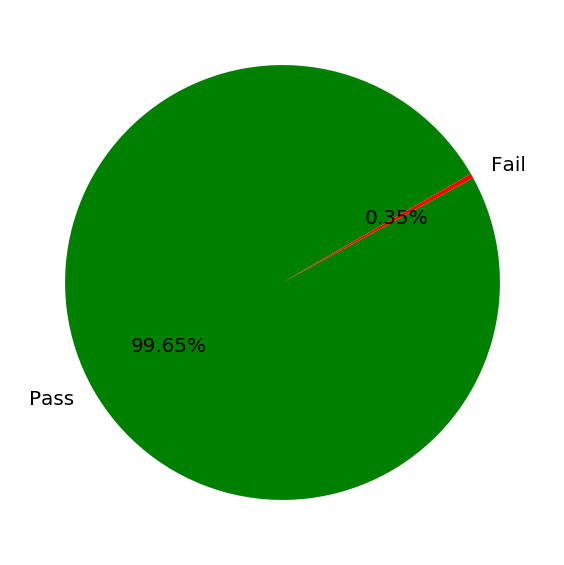

In [179]:
from matplotlib import style
import matplotlib as mpl
style.use('ggplot')

fig = plt.figure(1, figsize=(10,10))
labels = ['Pass','Fail']
colors = ['green','red']
ratio = [sum(stat_status_qc['rate'][0:3]),sum(stat_status_qc['rate'][3:7])]
patches, texts, autotexts=plt.pie(ratio, labels=labels, colors=colors, autopct='%.2f%%', shadow=False, startangle=30, textprops={'fontsize': 20})
texts[0].set_fontsize(20)
texts[1].set_fontsize(20)
plt.show()
#plt.savefig('./success_rate.png')

### Upload CSV Files to BigQuery

In [180]:
# columnlist=["sample","pass","status","dup","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]
# sample_qc_df_simple=sample_qc_df[columnlist]
# sample_qc_df_simple.to_csv('sample-based-analysis-v058-1-simple2.csv')

In [181]:
# table_id='mvp_wgs35_v058_1.sample_based_analysis'
# projectid='gbsc-gcp-project-mvp-test'

# pandas_gbq.to_gbq(
#     sample_qc_df_simple, table_id, project_id=projectid, if_exists='replace',
# )